<a href="https://colab.research.google.com/github/JSJeong-me/CNN-Daisy-Dandelion/blob/main/1_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline

In [3]:
!ls -l

total 8
drwx------ 5 root root 4096 Jan 25 06:33 drive
drwxr-xr-x 1 root root 4096 Jan 20 17:27 sample_data


In [4]:
!cp ./drive/MyDrive/flower.zip .

In [ ]:
!unzip flower.zip


In [7]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [8]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (1275, 150, 150, 3) 	Validation dataset shape: (364, 150, 150, 3)


In [9]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

In [10]:
batch_size = 50
num_classes = 2
epochs = 150
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['daisy', 'dandelion', 'dandelion', 'daisy', 'dandelion'] [0 1 1 0 1]


In [ ]:

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet',
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()


In [13]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9bb0073908>,input_2,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9bb007cb00>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9bbf312da0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9bbf312d68>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9bb0041fd0>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b68055d68>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9b6805a588>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9bb00412e8>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b6805f7b8>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b5139bf60>,block3_conv3,False


In [14]:
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: []


(1, 4, 4, 512)


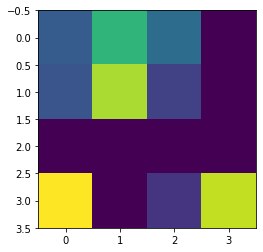

In [15]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [16]:
def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

In [17]:
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (1275, 8192) 	Validation Bottleneck Features: (364, 8192)


In [19]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/150
26/26 [==============================] - 1s 18ms/step - loss: 0.6106 - accuracy: 0.6389 - val_loss: 0.3579 - val_accuracy: 0.8516
Epoch 2/150
26/26 [==============================] - 0s 6ms/step - loss: 0.3532 - accuracy: 0.8432 - val_loss: 0.3226 - val_accuracy: 0.8709
Epoch 3/150
26/26 [==============================] - 0s 9ms/step - loss: 0.2662 - accuracy: 0.8807 - val_loss: 0.3106 - val_accuracy: 0.8681
Epoch 4/150
26/26 [==============================] - 0s 5ms/step - loss: 0.2443 - accuracy: 0.8983 - val_loss: 0.4838 - val_accuracy: 0.7802
Epoch 5/150
26/26 [==============================] - 0s 5ms/step - loss: 0.2043 - accuracy: 0.9188 - val_loss: 0.4371 - val_accuracy: 0.8407
Epoch 6/150
26/26 [==============================] - 0s 5ms/step - loss: 0.1654 - accuracy: 0.9260 - val_loss: 0.4257 - val_accuracy: 0.8187
Epoch 7/150
26/26 [==============================] - 0s 5ms/step - loss: 0.1471 - accuracy: 0.9517 - val_loss: 0.3036 - val_accuracy: 0.8681
Epoch 8/150


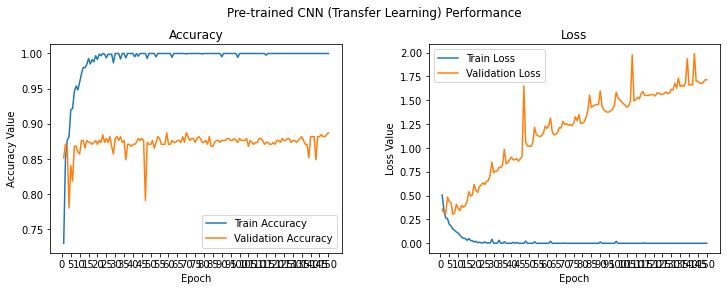

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,151))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 151, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 151, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('1-pretrained_cnn.h5')